### Version 1: Deterministic Approach

In [ ]:
# ! pip install -r requirements.txt
# ! playwright install

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
from langgraph.graph import MessagesState, START, END, StateGraph
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from playwright.async_api import Browser, BrowserContext, Page, async_playwright, Playwright, Locator
import asyncio
import os
import json

In [2]:
from agent import RT_Graph

In [5]:
async def run(playwright: Playwright):
    chromium = playwright.chromium # or "firefox" or "webkit".
    browser = await chromium.launch(headless=False)
    
    browser_context = await browser.new_context()
    page = await browser_context.new_page()
    await page.goto("https://ifaketextmessage.com/")

    # Kick off the DAG
    graph = RT_Graph()
    graph.set_page(page)
    agent = graph.compile()
    
    await agent.ainvoke({
        "selected_element" : "",
        "context_html" : "",
        "context_img" : "",
        "messages" : [],
    })

    # wait 10 secs
    await asyncio.sleep(10)
    await browser_context.close()
    await browser.close()
    

async def main():
    async with async_playwright() as playwright:
        await run(playwright)


await main()

page:  <Page url='https://ifaketextmessage.com/'>
set selected element:  BODY
ans:  wait
no tool call
------------------------------------------------
page:  <Page url='https://www.reddit.com/r/news/comments/1j58108/bc_to_toll_us_trucks_travelling_to_alaska_through/'>
set selected element:  BODY
ans:  wait
no tool call
------------------------------------------------
page:  <Page url='https://www.reddit.com/r/news/comments/1j58108/bc_to_toll_us_trucks_travelling_to_alaska_through/'>
set selected element:  PDP-COMMENT-SEARCH-INPUT
ans:  translate_message
THIS IS A MESSAGE BOX
PDP-COMMENT-SEARCH-INPUT
raw_value:  i love salah
text_to_translate:  i love salah
translated_text:  أحب صلاح -> I love Salah
------------------------------------------------
page:  <Page url='https://www.reddit.com/r/news/comments/1j58108/bc_to_toll_us_trucks_travelling_to_alaska_through/'>
set selected element:  PDP-COMMENT-SEARCH-INPUT
ans:  translate_message
THIS IS A MESSAGE BOX
PDP-COMMENT-SEARCH-INPUT
raw_va

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_OaEHN5RaDQhVIAvOh2vmjMFb, call_gd0uPjrxMWXn9bblebjSK5UE", 'type': 'invalid_request_error', 'param': 'messages.[1].role', 'code': None}}

In [10]:
class RT_State(TypedDict):
    selected_element: str
    context_html : str
    context_img : str
    messages : MessagesState
    page : object

chat = ChatOpenAI(model="gpt-4o-mini", temperature=0, api_key=os.getenv("OPENAI_API_KEY"))

def set_selected_element(state : RT_State):
    """ Sets the tag name of the element currently selected by the mouse om the selected_element field of the state """
    print("set selected element")
    if isinstance(state['page'], Page):
        hover_element = state['page'].locator(':hover')
        selected_elem = hover_element.evaluate('e => e.tagName')
        state['selected_element'] = selected_elem
    return state

@tool
def set_context_html(state : RT_State):
    """ Sets the inner html of the element currently selected by the mouse on the context_html field of the state """
    print("get context html")
    if  isinstance(state['page'], Page):
        context_html = state['page'].evaluate('document.querySelector(":hover").innerHTML')
        state['context_html'] = context_html
        state['messages'].append(SystemMessage(content=f"Here is the inner html of the element: {context_html}"))
    return state

@tool
def set_context_img(state : RT_State):
    """ Sets the image of the element currently selected by the mouse on the context_img field of the state """
    print("get context img")
    if isinstance(state['page'], Page):
        context_img = state['page'].screenshot()
        # pass thru an LLM to describe the image
        state['context_img'] = context_img
        state['messages'].append(SystemMessage(content=f"Here is the description of the image of the element: {context_img}"))
    return state
    
def decide_if_selected_is_message_box(state : RT_State):
    """ Decides if the selected element is a message box using an LLM with access to tools (set_context_html, set_context_img) """
    state['messages'].append(
        SystemMessage(content="""
            Is the selected element a message box?, You are an agent being used to translate a message as its being typed in a message box.
            You need to decide if the selected element is a message box. You have may have access to the following information:
            Name of the selected element: {selected_element}
                  
            You have the following tools at your disposal:
            set_context_html - to find the html of the page if you don't have it yet
            set_context_img - to find the screenshot of the page if you don't have it yet
                  
            If you think the selected element is a message box, return True. 
            If you think you need to use a tool, return the name of the tool
            Otherwise, return False.
    """.format(selected_element=state['selected_element']))
    )
    state['messages'].append(
        HumanMessage(content="Is the selected element a message box?")
    )
    ans = chat.invoke(state['messages'])
    state['messages'].append(ans)
    return state

def translate_message(self, state : RT_State):
        """ Translates the message in the selected element to Spanish """
        eval_str = "document.getElementsByTagName('{selected_element}')[0]".format(selected_element=state['selected_element'])
        if state['page'] and isinstance(state['page'], Page):
            raw_value = state['page'].evaluate(eval_str + ".value")
            text_to_translate = raw_value.split(" -> ")[0]
            state['messages'].append(
                HumanMessage(content=f"""Please translate the message: {text_to_translate} to {self.language_to_translate_to}. 
                             Keep the format of english_text -> spanish_text""")
            )
            translated_text = chat.invoke(state['messages'])
            print("translated_text: ", translated_text.content.strip())
            state['messages'].append(translated_text)
            state['page'].locator(eval_str).fill(translated_text.content.strip())
        return state
    

def cond_edge_is_messbox(state : RT_State):
    if state['messages'][-1].tool_calls:
        print("tool call")
        return state['messages'][-1].tool_calls[0].name
    elif state['messages'][-1].content.strip() == "True":
        print("is messbox")
        return "translate_message"
    else:
        print("no tool call")
        return "wait"

async def handle_wait(state : RT_State):
    """ Waits for 10 seconds and returns the state """
    print("waiting")
    await asyncio.sleep(10)
    return state


In [11]:
chat = chat.bind_tools([set_context_html, set_context_img])

In [29]:
p_state = RT_State(
    selected_element = "",
    context_html = "",
    context_img = "",
    messages = []
)

p_state['messages'].append(
    SystemMessage(content="""
            Is the selected element a message box?, You are an agent being used to translate a message as its being typed in a message box.
            You need to decide if the selected element is a message box. You have may have access to the following information:
            Name of the selected element: {selected_element}
                  
            You have the following tools at your disposal:
            set_context_html - to find the html of the page if you don't have it yet
            set_context_img - to find the screenshot of the page if you don't have it yet
                  
            If you think the selected element is a message box, return True. 
            If you think you need to use a tool, return the name of the tool
            Otherwise, return False.
    """.format(selected_element="glamorous_box"))
)

p_state['messages'].append(
    HumanMessage(content="Is the selected element a message box?")
)

ans = chat.invoke(p_state['messages'])
p_state['messages'].append(ans)

In [30]:
p_state['messages'][-1].tool_calls

[{'name': 'set_context_html',
  'args': {'state': {'selected_element': 'glamorous_box',
    'context_html': '',
    'context_img': '',
    'messages': {'messages': []}}},
  'id': 'call_Tm7UdDExZJQlUUcqmMoGJU5Q',
  'type': 'tool_call'}]

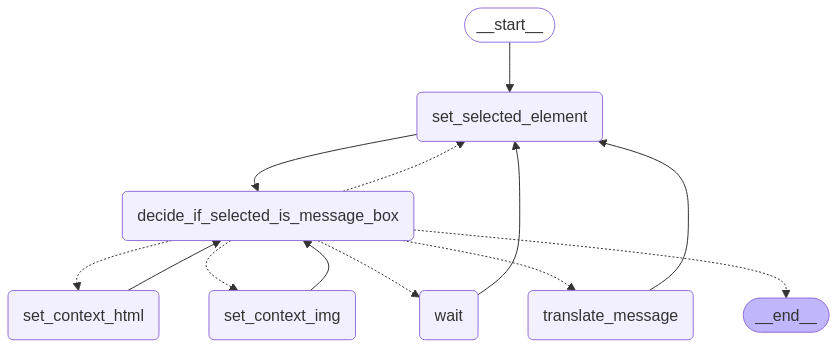

In [36]:
graph = StateGraph(RT_State)

graph.add_node("set_selected_element", set_selected_element)
graph.add_node("set_context_html", set_context_html)
graph.add_node("set_context_img", set_context_img)
graph.add_node("decide_if_selected_is_message_box", decide_if_selected_is_message_box)
graph.add_node("wait", handle_wait)
graph.add_node("translate_message", translate_message)

graph.add_edge(START, "set_selected_element")

graph.add_edge("set_selected_element", "decide_if_selected_is_message_box")
graph.add_edge("set_context_html", "decide_if_selected_is_message_box")
graph.add_edge("set_context_img", "decide_if_selected_is_message_box")
graph.add_conditional_edges(
    "decide_if_selected_is_message_box",
    cond_edge_is_messbox,
)
graph.add_edge("wait", "set_selected_element")
graph.add_edge("translate_message", "set_selected_element")
graph.compile()


In [11]:
agent = graph.compile()

await agent.ainvoke({
        "selected_element" : "",
        "context_html" : "",
        "context_img" : "",
        "messages" : [],
        "page" : "-"
        
})

NameError: name 'graph' is not defined

### Version 2

In [148]:
msg = SystemMessage(content="""
    You are an agent being used to decide whether to activate a translate function that extracts text and translates it in real time as its being typed in a message box. You need to be fast and efficient.
    The tool you're being used for updates text the user types every 3 to 6 seconds, while the user is in typing session. You must determine whether the user is in typing session. Feel free to sue the tools 
    to get more information about the user's situation. You can use tools to get a screenshot of the page and the html of the page. If you think the user is done with typing session, you should wait.
    If you think the user is typing, you must translate the text.

    You have access to the following information:
    Name of the selected element: {current_element_tag}
                    
    Consider previous messages to help you make a decision, if a tool has recently been used don't use it again.
    
    You have the following tools at your disposal:
    set_context_html - to find the html of the page
    set_context_img - to find the screenshot of the page
    
    RETURN IN THE FOLLOWING FORMAT: 
    {{
        "state" : [translate, set_context_html, set_context_img, wait]
        "reasoning" : [why you chose the state you did]
    }}
    
""".format(
    current_element_tag="textmessage_input", 
    # time_since_last_edit=1, 
    # last_edited_page_url="https://reddit.com/",
))

html = HumanMessage(content=f"After running the set_context_html tool, here is the inner html of the element:  <div class='textmessageinput'> <input type='text' placeholder='Text Message' /> </div> ")
img = HumanMessage(content=f"After running the set_context_img tool, here is the description of the screenshot of the page: An input box with a text 'My idea is to'")


res = chat.invoke([msg, html, img, msg])


In [149]:
if len(res.content) > 0:
    resp = json.loads(res.content)
    print(resp)
else:
    print(res.tool_calls[0]['name'])


{'state': 'translate', 'reasoning': "The user is currently typing in the input box, as indicated by the text 'My idea is to' present in the screenshot. Therefore, I will activate the translate function to translate the text in real time."}
